In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Predicción de géneros musicales 

### Índice
1. Normalización y categorización
2. Configuración de los entrenamientos
3. Entrenamiento de modelos
4. Evaluación de modelos
    1. Matriz de confusión
    2. Métricas y comparación de modelos
5. Análisis de variables más importantes
6. Conclusiones
7. Comparación con otros estudios

### 1. Normalización y categorización

Ya tenemos un dataset limpio y preprocesado practicamente listo para ser utilizado. Sin embargo, antes de poder entrenar un modelo de clasificación, necesitamos normalizar los datos y categorizar las etiquetas de los géneros musicales. Para ello, utilizaremos la función `LabelEncoder` de la librería `sklearn` como método de categorización de etiquetas y `min max scaler` para normalizar los datos.

Para comenzar, cargamos el dataset.

In [5]:
music_df = pd.read_csv('unique_non_null_music_genre.csv')
print(music_df.head())
print(music_df.dtypes)

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability    duration_ms  energy  instrumentalness key  \
0       0.00468         0.652  276803.084907   0.941           0.79200  A#   
1       0.01270         0.622  218293.000000   0.890           0.95000   D   
2       0.00306         0.620  215613.000000   0.755           0.01180  G#   
3       0.02540         0.774  166875.000000   0.700           0.00253  C#   
4       0.00465         0.638  222369.000000   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness    tempo  valence music_genre  
0     0.115 

Realizamos la transformaciones comentadas.

In [6]:
# We have to normalize the data and categorize all non-numeric data
numeric_cols = music_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('instance_id', errors='ignore')

categorical_cols = music_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop(['artist_name', 'track_name'], errors='ignore')

music_df[numeric_cols] = (music_df[numeric_cols] - music_df[numeric_cols].min()) / (music_df[numeric_cols].max() - music_df[numeric_cols].min())

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    music_df[col] = le.fit_transform(music_df[col])
    label_encoders[col] = le

print(music_df.head())
print(music_df.dtypes)

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out    0.272727   
1      46652.0  Thievery Corporation      The Shining Path    0.313131   
2      30097.0        Dillon Francis             Hurricane    0.282828   
3      62177.0              Dubloadz                 Nitro    0.343434   
4      24907.0           What So Not      Divide & Conquer    0.323232   

   acousticness  danceability  duration_ms    energy  instrumentalness  key  \
0      0.004699      0.639465     0.064887  0.941896          0.795181    1   
1      0.012751      0.607081     0.052872  0.890804          0.953815    5   
2      0.003072      0.604922     0.052321  0.755562          0.011847   11   
3      0.025502      0.771157     0.042313  0.700463          0.002540    4   
4      0.004669      0.624352     0.053709  0.587260          0.912651    9   

   liveness  loudness  mode  speechiness     tempo   valence  music_genre  
0  0

### 2. Configuración de los entrenamientos


Para la configuración de entrenamientos, usamos como features únicamente las columnas que queremos que sean utilizadas para la predicción. En este caso, utilizamos todas las columnas excepto la columna `music_genre` y aquellas columnas que no aportan información relevante para la predicción como `instance_id`, `artist_name` y `track_name`.

Como target, utilizamos la columna `music_genre` que es la que queremos predecir.

Finalmente, hemos decidido usar `KFold` como método de validación cruzada para evaluar el rendimiento del modelo. Divido el dataset en 5 partes. Se decide usar 5 partes ya que tenemos un dataset con un tamaño considerable, esto es equivalente a tener un 80% de los datos para entrenamiento y un 20% para validación.

In [7]:
# We have to split the data into features and target and use K-Fold cross validation
features = music_df.drop(columns=['instance_id', 'artist_name', 'track_name', 'music_genre'], errors='ignore')
target = music_df['music_genre']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Los modelos que se van a probar son los siguientes:
- Regresión logística
- SVM
- Arbol de decisión
- Random Forest
- Gradient Boosting
- KNN
- Naive Bayes

Todos ellos usando la implementación de `sklearn`.

In [8]:
# We define the models we want to use
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'GBoost': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': MultinomialNB()
}

### 3. Entrenamiento de modelos

Para cada modelo, se entrena usando las features y el target que comentamos anteriormente, haciendo uso de la validación cruzada definida. Guardamos los resultados para poder compararlos posteriormente.

In [9]:
# Train models and get predictions
predictions = {}

for model_name, model in tqdm(models.items(), desc="Training Models"):
    print(f'Training {model_name}...')
    pred = cross_val_predict(model, features, target, cv=kf)
    predictions[model_name] = pred

print('Done training!')

Training Models:   0%|          | 0/7 [00:00<?, ?it/s]

Training Logistic Regression...


Training Models:  14%|█▍        | 1/7 [01:16<07:37, 76.23s/it]

Training SVM...


Training Models:  29%|██▊       | 2/7 [06:14<17:13, 206.65s/it]

Training Decision Tree...


Training Models:  43%|████▎     | 3/7 [06:18<07:37, 114.25s/it]

Training Random Forest...


Training Models:  57%|█████▋    | 4/7 [07:29<04:52, 97.37s/it] 

Training GBoost...


Training Models:  71%|███████▏  | 5/7 [28:12<17:00, 510.33s/it]

Training KNN...


Training Models: 100%|██████████| 7/7 [28:15<00:00, 242.17s/it]

Training Naive Bayes...
Done training!


### 4. Evaluación de modelos
Una vez se han entrenado todos los modelos, se evalúan los resultados obtenidos. Se comparan los resultados de cada modelo y se hace un estudio de cual ha tenido mejor rendimiento. Para ello se comienza con un estudio visual mediante la representación de la matriz de confusión + accuracy. Posteriormente se entrará más en detalle con distintas métricas.

#### 4.1 Matriz de confusión
Definimos una función para que represente la matriz de confusión como un heatmap, normalizado entre 0 y 1 para poder comparar los resultados de cada género sin importar el número de instancias que haya de cada uno. Este tipo de gráfica nos aportará información valiosa ya que se puede ver de forma muy sencilla si el modelo está prediciendo correctamente los géneros, mirando el color de la diagonal principal.

In [10]:
class_names = label_encoders['music_genre'].classes_

def get_metrics(target, predictions, model_name):
    conf_matrix = confusion_matrix(target, predictions[model_name])
    accuracy = accuracy_score(target, predictions[model_name])

    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Accuracy of the model
    print(f'{model_name} - Accuracy: {accuracy}')

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Normalized) for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Ahora para cada modelo, se representará la matriz de confusión.

Logistic Regression - Accuracy: 0.5093020707790074


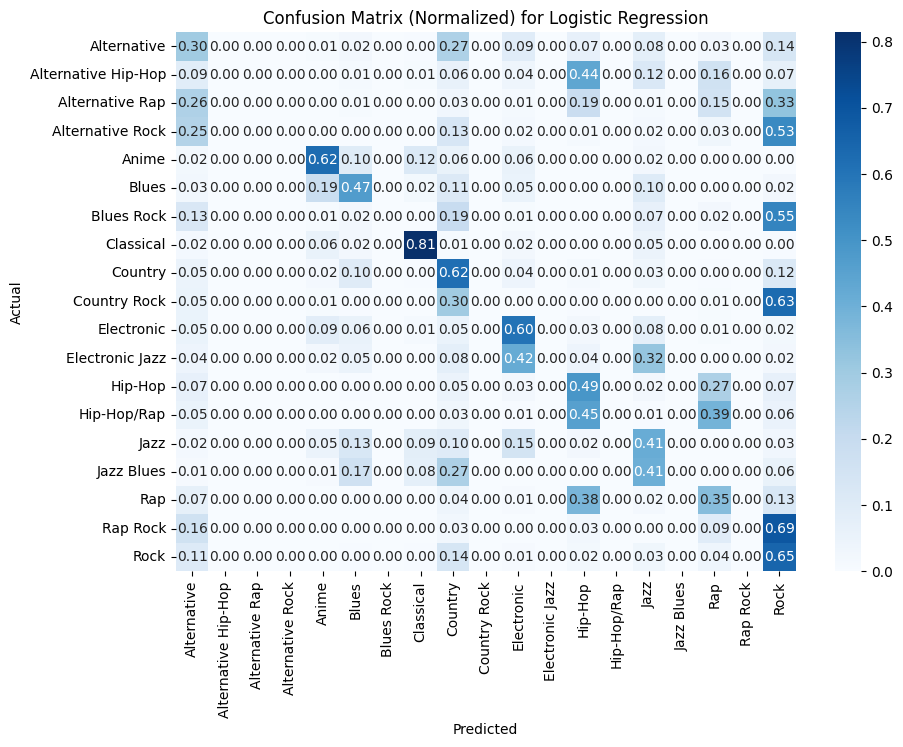

In [11]:
# Logistic Regression metrics
get_metrics(target, predictions, 'Logistic Regression')

SVM - Accuracy: 0.48787115152843213


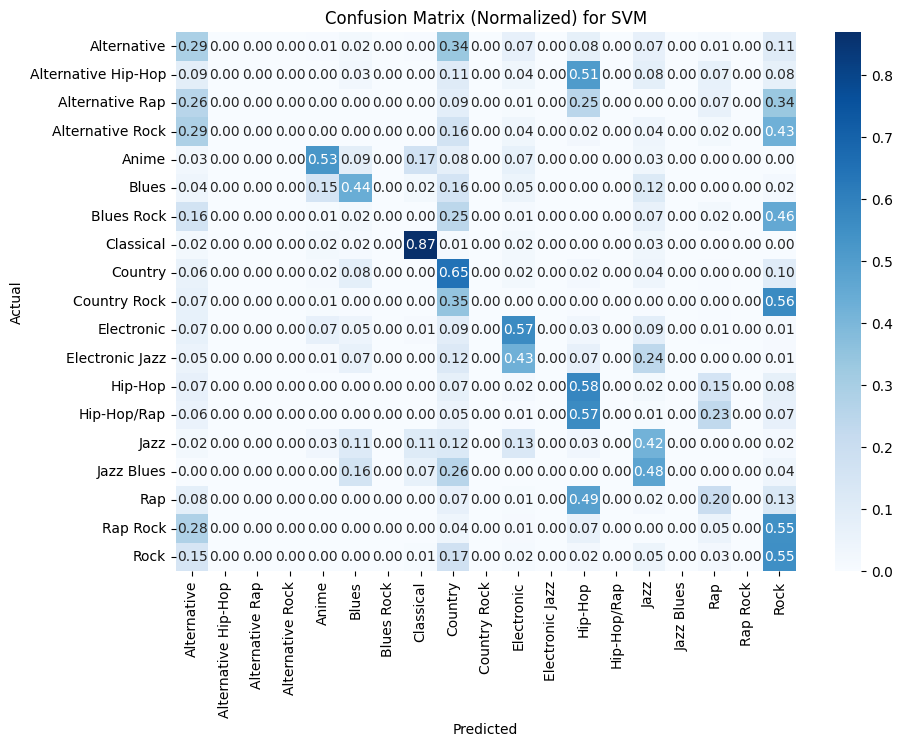

In [12]:
# SVM metrics
get_metrics(target, predictions, 'SVM')

Decision Tree - Accuracy: 0.4429056645118878


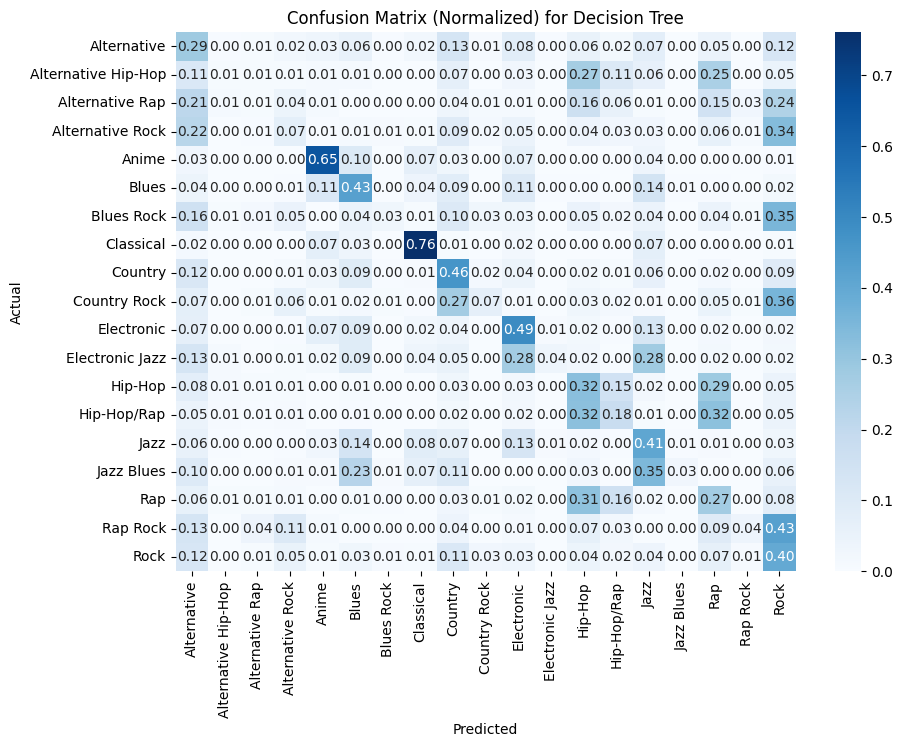

In [13]:
# Decision Tree metrics
get_metrics(target, predictions, 'Decision Tree')

Random Forest - Accuracy: 0.5751944779226471


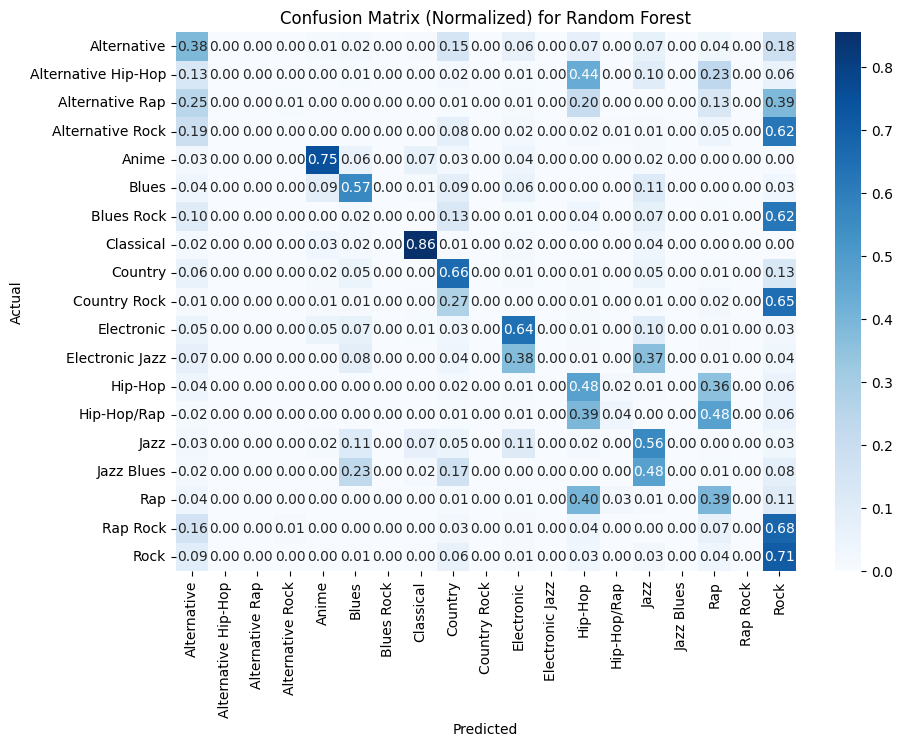

In [14]:
# Random Forest metrics
get_metrics(target, predictions, 'Random Forest')

GBoost - Accuracy: 0.5730031773857784


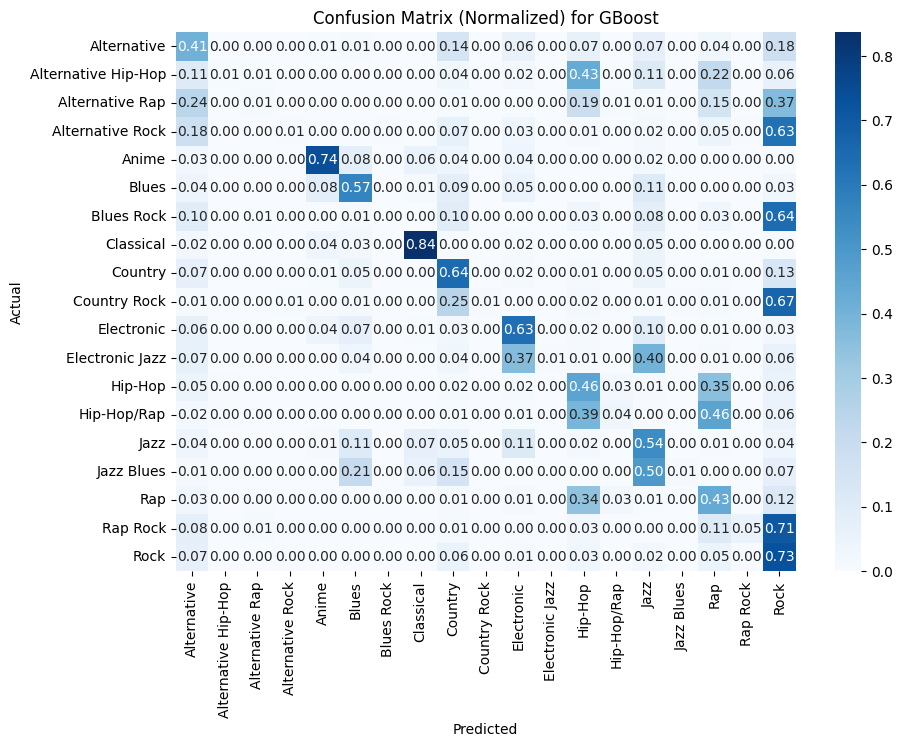

In [15]:
# Gradient Boosting metrics
get_metrics(target, predictions, 'GBoost')

KNN - Accuracy: 0.4244768269968226


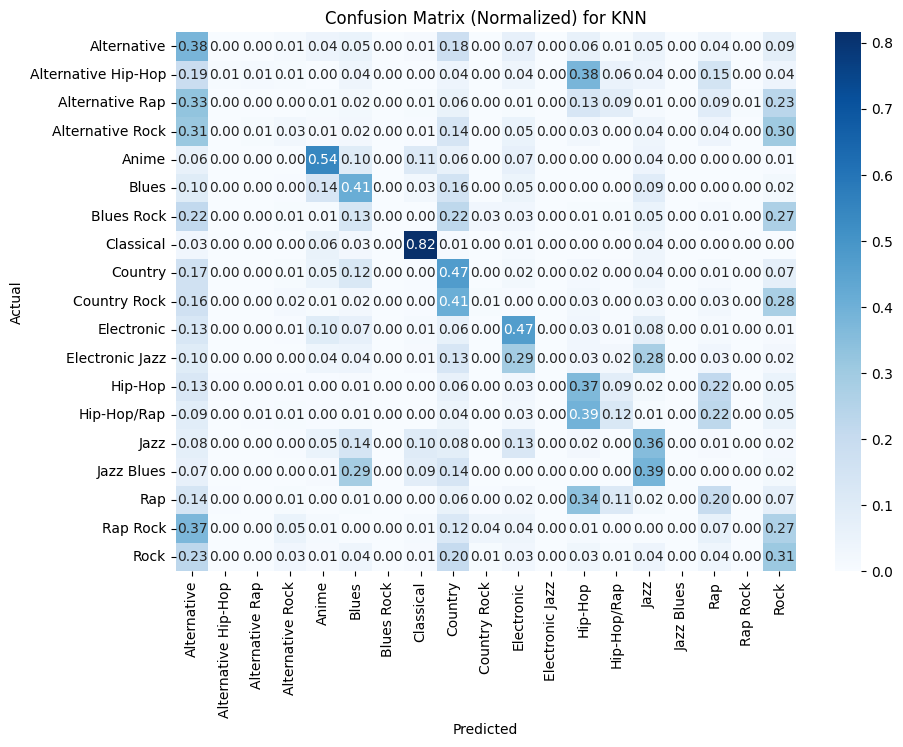

In [16]:
# KNN metrics
get_metrics(target, predictions, 'KNN')

Naive Bayes - Accuracy: 0.3078996384354114


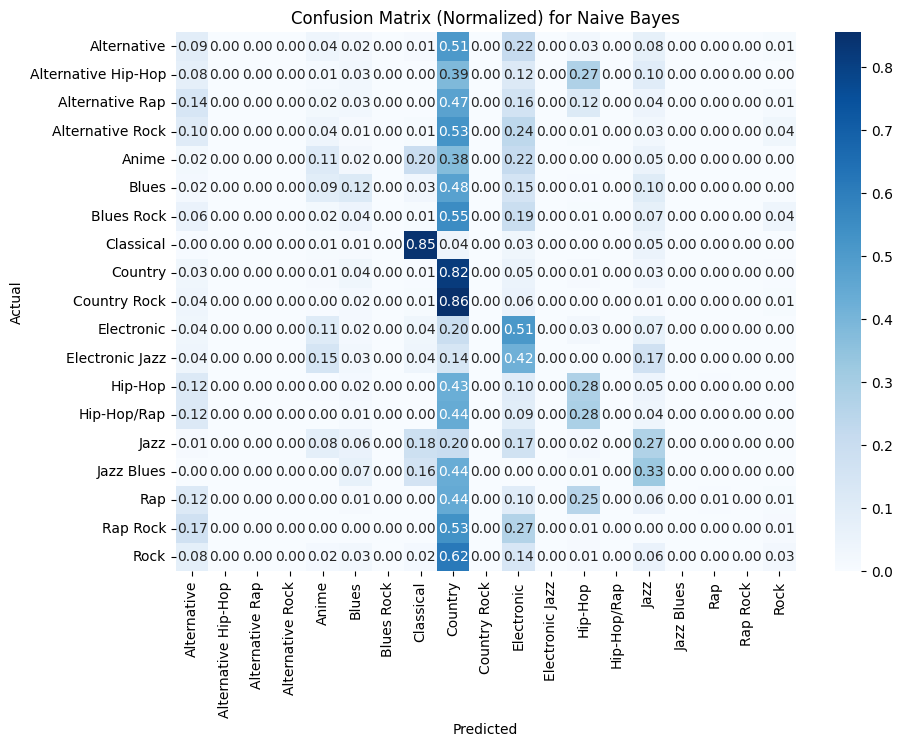

In [17]:
# Naive Bayes metrics
get_metrics(target, predictions, 'Naive Bayes')

De un vistazo podemos observar que los mejores modelos son Random Forest y Gradient Boosting, ya que su accuracy es de 0.575 y 0.573 respectivamente. A simple vista parece un resultado bastante pobre, pero hay que tener en cuenta que estamos clasificando 19 géneros musicales. Además la tarea de clasificación de géneros musicales es bastante complicada ya que no es una ciencia exacta.

Hay que tener en cuenta que los datos con los que estamos trabajando no dan información típica para clasificar géneros musicales y la mayor parte de la información es subjetiva y generada por ia.

Dejando de lado este apunte, queremos mencionar que hay subgéneros que a pesar de haber sido clasificados 'incorrectamente' tienen una relación muy estrecha con el género original. Esto se puede ver sobre todo en aquellos subgéneros del rock, como el Rap Rock, Country Rock, Alternative Rock y Blues Rock, que en lugar de clasificarse en su subgénero concreto han sido clasificados en el género Rock, lo cual no podríamos considerar erróneo. Algo parecido ocurre con el Hip Hop y el Rap, y sus subgéneros, que han sido clasificados a partes iguales entre Hip Hop y Rap, lo cual también es en parte correcto. Tambien se puede ver con otros casos de género-subgénero como el jazz y el electronic jazz.

Los géneros que más facilmente han sido predichos son la música clásica, rock y anime de forma generalizada, mientra que por ejemplo el género el alternative ha sido más difuso de clasificar. Nuestra percepción es que este género es muy amplio y puede abarcar características de otros géneros, lo cual puede haber dificultado su clasificación. A pesar de ello, el modelo ha sido capaz de clasificar correctamente un 41% de las instancias de este género, usando el modelo gradient boosting.

#### 4.2 Métricas y comparación de modelos

In [18]:
# We calculate f1 score for each model
classification_reports = {}
for model_name in models.keys():
    print(f'{model_name} - Classification Report:')
    classification_reports[model_name] = classification_report(target, predictions[model_name], target_names=class_names, zero_division=0)
    print(classification_reports[model_name])

Logistic Regression - Classification Report:
                     precision    recall  f1-score   support

        Alternative       0.36      0.30      0.33      3878
Alternative Hip-Hop       0.00      0.00      0.00       142
    Alternative Rap       0.00      0.00      0.00       137
   Alternative Rock       0.00      0.00      0.00       540
              Anime       0.61      0.62      0.62      4954
              Blues       0.52      0.47      0.49      4651
         Blues Rock       0.00      0.00      0.00       134
          Classical       0.77      0.81      0.79      4936
            Country       0.43      0.62      0.51      4547
       Country Rock       0.00      0.00      0.00       291
         Electronic       0.57      0.60      0.59      4783
    Electronic Jazz       0.00      0.00      0.00       167
            Hip-Hop       0.38      0.49      0.43      3225
        Hip-Hop/Rap       0.00      0.00      0.00      1521
               Jazz       0.48      0.4

Aquí podemos observar cómo ha sido el rendimiento de cada modelo al predecir cada género utilizando diferentes métricas. Viendo el f-measure de cada modelo sabemos que Random Forest y Gradient Boosting son los mejores modelos, cuyas medias ponderadas son 0.56, aunque tienen una dificultad considerable para predecir los subgéneros. 

Uno de los motivos de este bajo rendimiento es el desequilibrio de las clases. Al crear nuevas clases y al ser estas tan minoritarias los modelos tienden a predecir los subgéneros como alguno de los géneros que los conforman. Esto nos da indicios de que el modelo en general es capaz de detectar los patrones de forma aceptable, pero que sería necesario un trabajo de balanceo de los datos para mejorar dichas métricas.

#### 5. Análisis de variables más importantes

Para finalizar nuestro estudio hemos decidio realizar un análisis de las variables que los modelos han considerado más relevantes para la predicción. Para ello, utilizamos la función `feature_importances_` de los modelos Random Forest y Gradient Boosting, los cuales han sido los que mejor resultado han tenido. Esto nos permitirá ver varias cosas:

- Si aquellos aspectos que se percibían en la previsualización se cumplen.
- Los aspectos que los modelos han considerado más relevantes para la predicción.
- Las diferencias entre los modelos a la hora de considerar las variables.

Para ello, y como hemos utilizado validación cruzada anteriormente, tendremos que volver a entrar los modelos. En este caso usaremos un 80% del dataset para entrenarlo.

En el preprocesamiento ya realizamos un análisis de correlación de la escala, pensando que el resultado sería el esperado y con objetivo de reducir la dimensión del dataset. Para ello utilizamos el test chi cuadrado y la V de Cramer, con lo que concluimos que la escala tenía una correlación débil, pero que aun así seguía guardando una relacion con el género musical. Al realizar este análisis podremos ver si la escala ha sido considerada relevante por los modelos, o si por el contrario, no ha sido tenida tanto en cuenta como esperábamos.

In [19]:
# We split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(f'Training set size: {len(X_train)}')
print(f'Testing set size: {len(X_test)}')

Training set size: 36508
Testing set size: 9127


In [20]:
# We train Random Forest and Gradient Boosting models on the training set
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)

GradientBoostingClassifier()

In [21]:
# We analyze the feature importance of both models
rf_feature_importance = rf.feature_importances_
xgb_feature_importance = xgb.feature_importances_

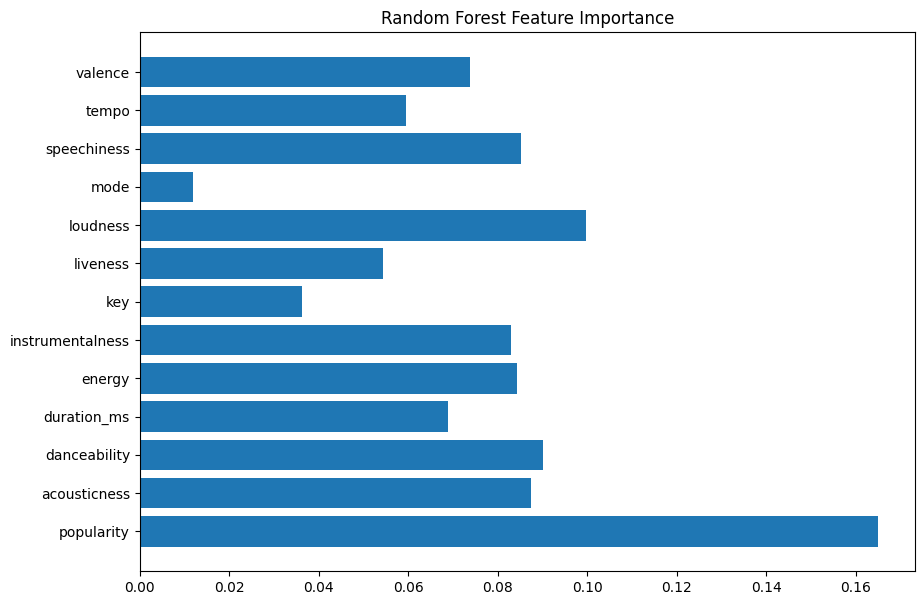

In [22]:
# We plot the feature importance of both models
plt.figure(figsize=(10, 7))
plt.barh(features.columns, rf_feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

En el caso de Random Forest, vemos que la modalidad y la escala son las variables con menos importancia, teniendo bastante diferencia con las variables más importantes, que en este caso son (en orden descendente):

- Popularity
- Loudness
- Danceability
- Acousticness
- Speechiness
- Energy
- Instrumentalness

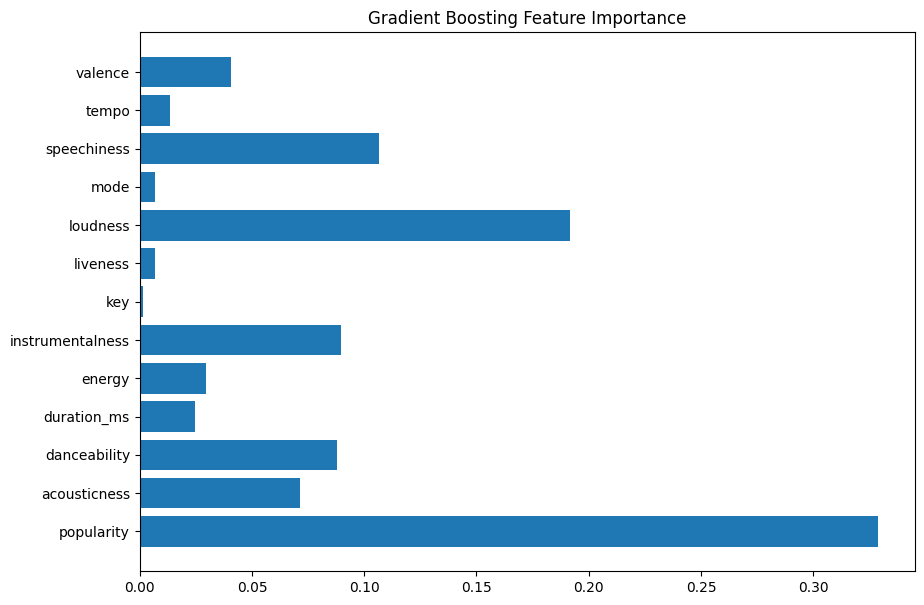

In [23]:
# We plot the feature importance of Gradient Boosting
plt.figure(figsize=(10, 7))
plt.barh(features.columns, xgb_feature_importance)
plt.title('Gradient Boosting Feature Importance')
plt.show()

En el caso de Gradient Boosting ha habido mayor discriminación. Las variables menos importantes siguien siendo la escala y la modalidad, y le siguen variables como liveness y tempo. Por otro lado las variables más importantes son:

- Popularity
- Loudness
- Speechiness
- Instrumentalness
- Danceability
- Acousticness

Esto nos hace llegar a la conclusión de que estos atributos, al haberse repetido como más importantes en ambos modelos, son los que más influyen en la predicción de géneros musicales, en este dataset en concreto. Además, podemos ver que la escala y la modalidad no han sido consideradas relevantes, es decir, nuestra hipótesis de la escala inicial podrímos decir que es correcta.

#### 6. Conclusiones

Con esto, podemos concluir que los modelos entrenados han sido capaces de aprender correctamente patrones que diferencien géneros musicales. A pesar de que en cuanto a rendimiento los modelos son muy mejorables hay que tener en cuenta los datos con los que hemos trabajado. La mayoría de información o no estaba muy relacionada en sí con el género musical, como `key` o `mode`, o era información subjetiva generada por IA, como `danceability`.

Asimismo, tenemos que tener en cuenta que ante la presencia de canciones duplicadas hemos acabado aumentando el número de géneros de 10 a 19, teniendo muchos subgéneros que han acabado siendo predichos como alguno de los géneros que lo conformaban, por lo que no podemos considerarlas erróneas, pues los modelos han detectado los patrones de uno de los géneros al que pertenecerían.

Hemos podido comprobar la importancia de las variables y ver aquellas que los modelos han considerado más relevantes para la predicción. Por otro lado hemos podido verificar que la escala no ha sido considerada relevante por los modelos, afirmando nuestra hipótesis inicial.

Estos resultados, con el mismo dataset, se podrían mejorar balanceando los datos, los cuales acabaron muy desbalanceados tras la creación de los nuevos subgéneros. También se podría mejorar la velocidad de los modelos utilizando técnicas de reducción de dimensionalidad o extracción de características intentando minimizar la pérdida de información al utilizar dichas técnicas.

Finalmente, creemos que la adición de datos objetivos como el compás, armonía/acordes,  melodías/escalas, instrumentos involucrados, tipos de efectos de sonido, calidad de audio, temática, patrones rítmicos... Harían que los resultados mejoraran exponencialmente. Esta información podría ser extraída de la propia canción, y no dependería de la subjetividad de la IA y los sesgos que esta pueda tener.

#### 7. Comparación con otros estudios

En general tras hacer una comparación de nuestros resultados con los de otros estudios en kaggle, podemos verificar que en la mayoría de ocasiones mejoramos el accuracy de los modelos, teniendo preprocesamiento más completo que añade 9 subgéneros nuevos.

- https://www.kaggle.com/code/tarunikar54/music-prediction
- https://www.kaggle.com/code/grandwizard/music-genre-classification-with-logreg-svm-knn
- https://www.kaggle.com/code/yashmehta648/music-genre-prediction

